<a href="https://colab.research.google.com/github/AndrewDavidRatnam/HandsonWorkingML/blob/main/Sequences_with_RNNs_and_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMports and STUFFs

In [ ]:
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

if not (tf.config.list_physical_devices('TPU') or tf.config.list_physical_devices('GPU') ):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
if tf.config.list_physical_devices("TPU"):
  print("LEZZZZZZ GOOOO  TPU") #ALL GOOD
else:
  print("Using GPU")

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.
Using GPU


## Sketch RNN Dataset

In [ ]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 [==============================] - 16s 0us/step


In [ ]:
#creating paths for training tf records and eval(val and test) tf records
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")] )
eval_files = sorted(
    [ str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")] )

In [ ]:
len(train_files), len(eval_files)

(10, 10)

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
  test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
  train_classes = train_classes_file.readlines()

assert train_classes == test_classes, "Something went wrong with data loading or reading data"

class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)[::10]

['aircraft carrier',
 'asparagus',
 'bat',
 'binoculars',
 'brain',
 'cactus',
 'canoe',
 'church',
 'couch',
 'diving board',
 'dumbbell',
 'feather',
 'floor lamp',
 'goatee',
 'headphones',
 'hot dog',
 'key',
 'lighter',
 'marker',
 'mountain',
 'octagon',
 'paper clip',
 'pickup truck',
 'popsicle',
 'rake',
 'saxophone',
 'shorts',
 'snorkel',
 'squiggle',
 'strawberry',
 'syringe',
 'the great wall of china',
 'tractor',
 'van',
 'wine glass']

In [ ]:
@tf.function
def parse(data_batch):
  feature_descriptions = {
      "ink" : tf.io.VarLenFeature(dtype=tf.float32),
      "shape" : tf.io.FixedLenFeature([2], dtype=tf.int64),
      "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
  }
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  flat_sketches = tf.sparse.to_dense(examples["ink"])
  sketches = tf.reshape(flat_sketches, shape= [tf.size(data_batch), -1, 3])
  lengths = examples["shape"][:, 0]
  labels = examples["class_index"][:, 0]
  return sketches, lengths, labels



In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
  dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=tf.data.AUTOTUNE)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
  return dataset.prefetch(tf.data.AUTOTUNE)



In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10_000)
val_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

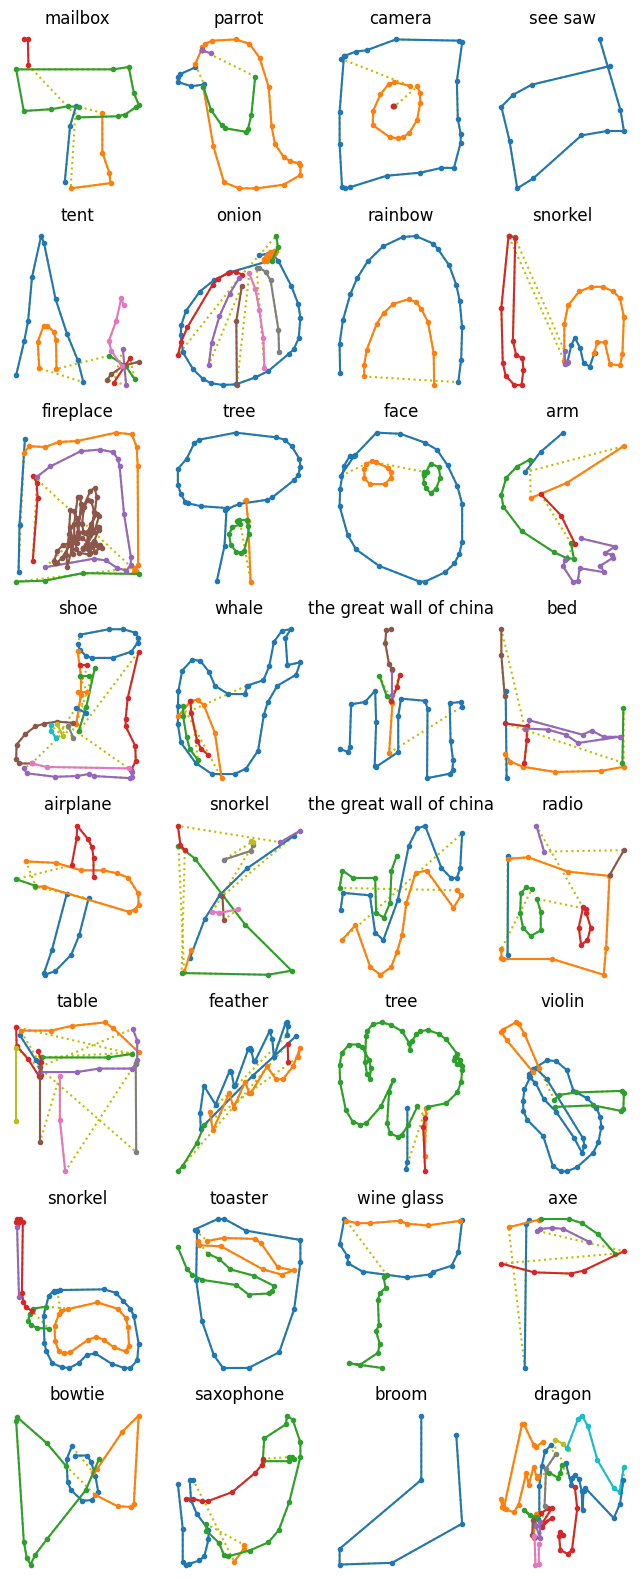

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    ##Origin Point: The origin point [0., 0., 0.] is added to the beginning of the sketch array. This ensures the sketch starts from the origin.

    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    #Find Stroke Ends: Identify the indices where a stroke ends, indicated by the value 1.0 in the last column.

    coordinates = sketch[:, :2].cumsum(axis=0)
    #Cumulative Sum: Calculate the cumulative sum of the coordinates. This converts relative movements into absolute positions.

    strokes = np.split(coordinates, stroke_end_indices + 1)
    #Split Strokes: Split the coordinates array into individual strokes based on the end indices.

    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    #Plot Sketch: Plot the entire sketch as a dotted yellow line, and then plot each stroke as a solid line.
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 2, n_rows * 2.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

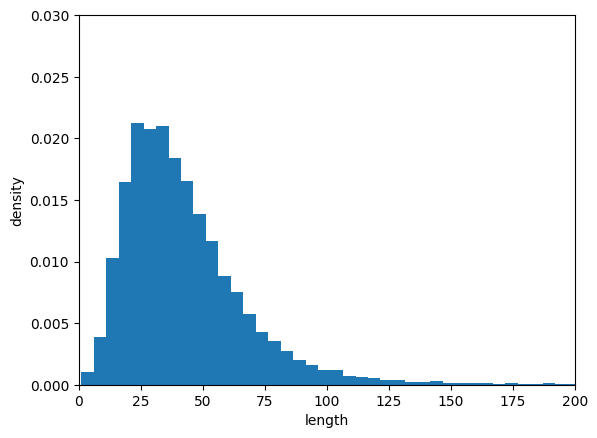

In [ ]:
#visulazing the number of points
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
  return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(val_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers
])